In [1]:
from casadi import *
import do_mpc
import numpy as np

import matplotlib.pyplot as plt
plt.ion()
%matplotlib inline

In [2]:
model = do_mpc.model.Model('continuous')

In [3]:
x = model.set_variable('_x','x')
y = model.set_variable('_x','y')
theta = model.set_variable('_x','theta')

v = model.set_variable('_u','v')
w = model.set_variable('_u','w')

dx = model.set_variable('_z','dx')
dy = model.set_variable('_z','dy')
dtheta = model.set_variable('_z','dtheta')

x_goal = np.array([10,0,0])

In [4]:
model.set_rhs('x',dx)
model.set_rhs('y',dy)
model.set_rhs('theta',dtheta)

In [5]:
model_equation = vertcat(
    dx - v*np.cos(theta),
    dy - v*np.sin(theta),
    dtheta - w
)

model.set_alg('model_equation', model_equation)

In [6]:
model.set_expression('cost',sqrt((x_goal[0] - x)**2+(x_goal[1] - y)**2))

SX(sqrt((sq((10-x))+sq(y))))

In [7]:
model.setup()

In [8]:
mpc = do_mpc.controller.MPC(model)

In [9]:
setup_mpc = {
    'n_horizon': 100,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.04,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [10]:
mterm = model.aux['cost']
lterm = model.aux['cost']

mpc.set_objective(mterm,lterm)

mpc.set_rterm(v=0.1,w=0.1)

In [11]:
mpc.bounds['lower','_u','v'] = -2
mpc.bounds['upper','_u','v'] = 2
mpc.bounds['lower','_u','w'] = -2
mpc.bounds['upper','_u','w'] = 2

In [12]:
mpc.setup()

In [13]:
estimator = do_mpc.estimator.StateFeedback(model)
simulator = do_mpc.simulator.Simulator(model)


In [14]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'idas',
    'abstol': 1e-8,
    'reltol': 1e-8,
    't_step': 0.04
}

simulator.set_param(**params_simulator)

In [15]:
simulator.setup()

In [16]:
simulator.x0 = np.zeros(3)

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [17]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     8903
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1501

Total number of variables............................:     2915
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2703
Total number of inequality c

In [18]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

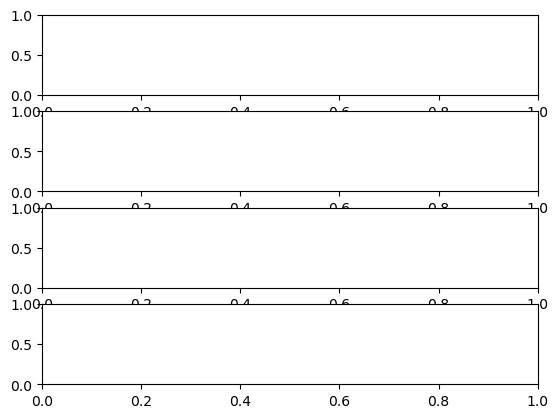

In [19]:
fig = plt.figure()

ax1 = plt.subplot2grid((4, 1), (0, 0))
ax2 = plt.subplot2grid((4, 1), (1, 0))
ax3 = plt.subplot2grid((4, 1), (2, 0))
ax4 = plt.subplot2grid((4, 1), (3, 0))

In [20]:
mpc_graphics.add_line(var_type='_x', var_name='x', axis=ax1)
mpc_graphics.add_line(var_type='_x', var_name='y', axis=ax2)
mpc_graphics.add_line(var_type='_u', var_name='v', axis=ax3)
mpc_graphics.add_line(var_type='_u', var_name='w', axis=ax4)

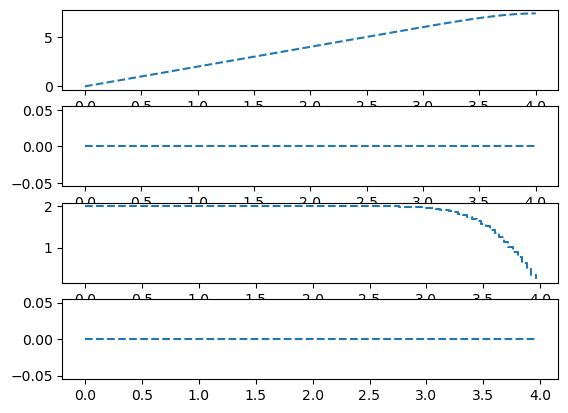

In [21]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

In [22]:
%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 100
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [24]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()


anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
gif_writer = ImageMagickWriter(fps=20)
anim.save('anim_dip.gif', writer=gif_writer)